# Imports and Definitions

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
%load_ext autoreload
%autoreload 2
SEED = 1223

In [3]:
param_cols = ['batch_size','input_size','output_size']
models = {}
estimates = {}

# Linear Module
## Load Data

In [4]:
data_unnormalized = pd.read_csv('../data/linear-energies-parsed.csv')
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True, slurm_log_info=('../data/slurm-7511929.out','linear'))

Dropped observations with the following indices: [22, 152, 208, 217, 285, 362, 412, 476]
Final shape of data set: (492, 25)


## Feature Set: Parameters

In [5]:
print(f"Used features: {param_cols}")
dfs = split_data_set(data, param_cols, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size']
Number of observations: train/344, val/98 and test-set/50
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -2.971e-05 (± 8.375e-06)
Validation R2 Score: 0.999
Validation MSE: 3.561e-05


Test R2 Score: 0.999
Test MSE: 3.494e-05


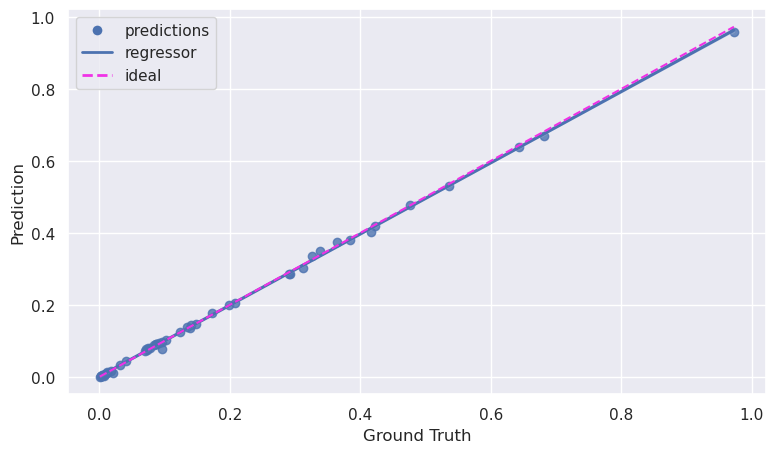

In [6]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [7]:
# save model & estimates
models['param'] = model
estimates['param'] = y_hat

### Notes
- Compared to the conv2d model, here a standard LinearRegressor without Polynomial Features performs reasonable well with a test R2 score of over 0.73
- but even with just second degree polynomials the score boosts to 0.97 on the validation and test-set.
- degree 3 boosts the score to 0.99, with MSE of two magnitudes smaller
- no benefit from allowing terms other than interaction_only

## Feature-Set: Module Parameters + Log-Parameters

In [8]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size', 'log_batch_size', 'log_input_size', 'log_output_size']
Number of observations: train/344, val/98 and test-set/50
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -1.931e-05 (± 3.134e-06)
Validation R2 Score: 1.000
Validation MSE: 1.733e-05


Test R2 Score: 1.000
Test MSE: 1.601e-05


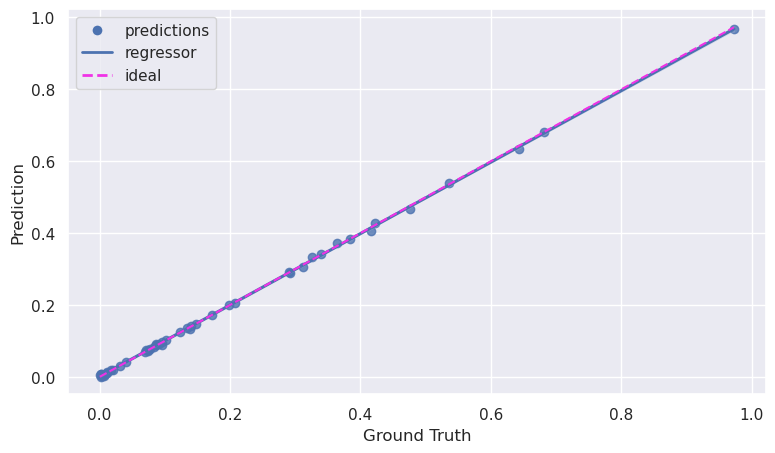

In [9]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [10]:
# save model & estimates
models['param_log_param'] = model
estimates['param_log_param'] = y_hat

### Notes
- adding log terms doesn't add any real improvement with just linear terms
- with degree 3 we achieve a perfect R2 score of 1.0 with a significant reduction in MSE
- no improvements with Lasso

## Feature-Set: MACs Only

In [11]:
dfs = split_data_set(data, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/344, val/98 and test-set/50
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -3.247e-05 (± 7.160e-06)
Validation R2 Score: 0.999
Validation MSE: 3.050e-05


Test R2 Score: 0.999
Test MSE: 3.556e-05


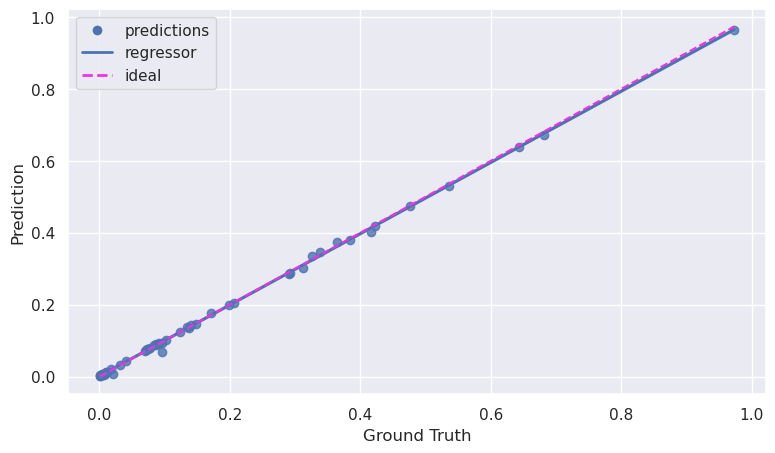

In [12]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [13]:
# save model & estimates
models['macs'] = model
estimates['macs'] = y_hat

### Notes
- out-of-the-box performance very good
- performs equally with param model with polynomial terms
- but MSE quite a bit larger compared to previous model, yet I believe the tradeoff is clear due to the simplicity of this model

# Feature-Set: Module Parameters + MACs

In [14]:
dfs = split_data_set(data, param_cols + ['macs'], SEED)
print(f"Used features: { param_cols + ['macs']}")
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/344, val/98 and test-set/50
Used features: ['batch_size', 'input_size', 'output_size', 'macs']
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -2.961e-05 (± 7.447e-06)
Validation R2 Score: 0.999
Validation MSE: 3.379e-05


Test R2 Score: 0.999
Test MSE: 3.593e-05


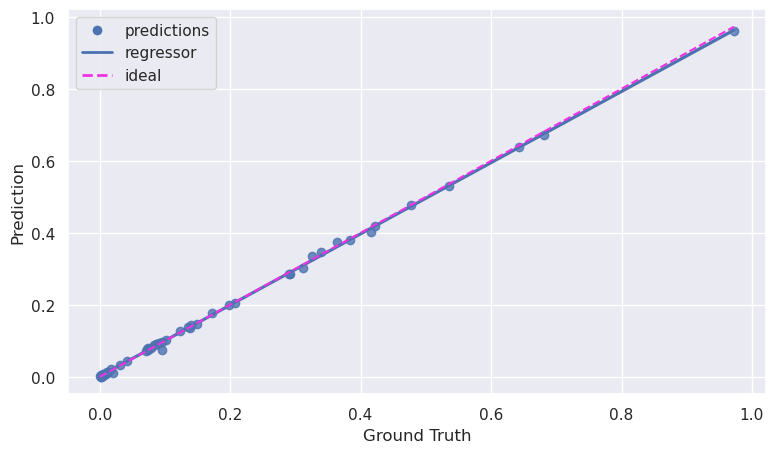

In [15]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [16]:
# save model & estimates
models['param_macs'] = model
estimates['param_macs'] = y_hat

### Notes
- no performance improvement over MACs only model
- can achieve 1.0 R2 with polynomial interaction only terms of degree 3, although with a higher MSE compared to param+log_param
- lasso provides no improvements here

## Feature-Set: Module Parameters + Log-Parameters + MACs

In [17]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log + ['macs']}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size', 'log_batch_size', 'log_input_size', 'log_output_size', 'macs']
Number of observations: train/344, val/98 and test-set/50
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -2.615e-05 (± 4.291e-06)
Validation R2 Score: 0.999
Validation MSE: 2.623e-05


Test R2 Score: 0.999
Test MSE: 2.828e-05


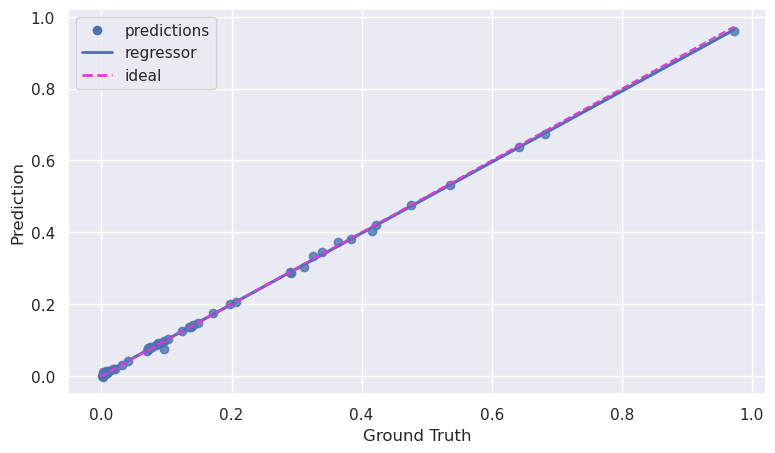

In [18]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [19]:
# save model & estimates
models['param_log_param_macs'] = model
estimates['param_log_param_macs'] = y_hat

### Notes
- no improvement yielded by this configuration over previous ones

# Comparison of all models

param                               0.999
param_log_param                     1.0
macs                                0.999
param_macs                          0.999
param_log_param_macs                0.999


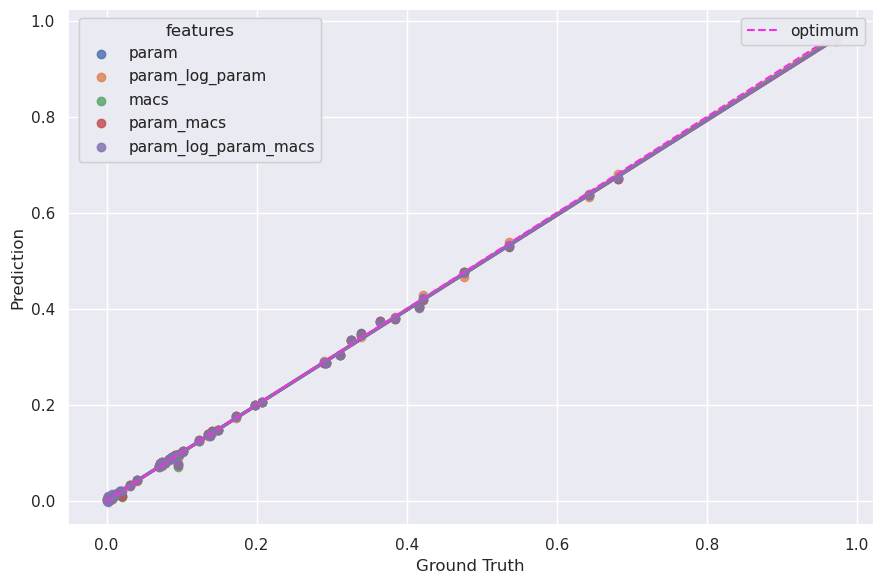

In [20]:
df_to_plot = pd.DataFrame(columns=["features","y_hat",'y'])
for model_name, model in models.items():
    new_df = pd.DataFrame(data={'features':[model_name]*len(dfs['y_test']),'y_hat':np.squeeze(estimates[model_name]),'y':np.squeeze(dfs['y_test'])})
    df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)
    print(f"{'{:<35}'.format(model_name)} {round(r2_score(dfs['y_test'], estimates[model_name]), 3)}")
min_x = min(min(df_to_plot.y_hat),min(df_to_plot.y))
max_x = max(max(df_to_plot.y_hat),max(df_to_plot.y))
g = sns.lmplot(data=df_to_plot, x="y", y="y_hat", hue="features", ci=95, height=6, aspect=1.5, facet_kws={'legend_out':False}, markers='o')
plt.plot([min_x, max_x], [min_x, max_x],ls='--', marker='', label='optimum', color="#f032e6")
line = Line2D([0], [0], ls='--', label='optimum', color='#f032e6')
g.set(xlabel='Ground Truth', ylabel='Prediction')
sns.move_legend(g, "upper left", bbox_to_anchor=(.09, .97))
legend1 = g.legend
legend2 = plt.legend(handles = [plt.plot([],ls="--", color=line.get_color())[0]], labels=[line.get_label()], loc='upper right')
g.fig.add_artist(legend1)
g.fig.add_artist(legend2)